In [58]:
import os
from typing import List, Literal, TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv
from langchain_core.runnables import RunnableConfig

In [ ]:
load_dotenv()

In [46]:
# ==========================================
# Configuration
# ==========================================
PDF_PATH = "xx.pdf"
CHROMA_PERSIST_DIR = "./chroma_db"
#COLLECTION_NAME = "dspy_book_collection"
COLLECTION_NAME = "rag_test_collection"

In [50]:
# Initialize Global Models
llm_engine = ChatOpenAI(model="gpt-4o-mini")
embedding_engine = OpenAIEmbeddings()

lm_judge = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
)

In [51]:
vector_store = Chroma(
    collection_name=COLLECTION_NAME,  # Must match the original collection name
    embedding_function = embedding_engine,
    persist_directory = CHROMA_PERSIST_DIR   # The directory where data was saved
)

# Now you can run searches immediately without re-adding documents
# results = vector_store.similarity_search("What is the open source model?")

In [52]:
vector_store._collection.count()

254

In [38]:
#import chromadb

#client = chromadb.PersistentClient(CHROMA_PERSIST_DIR)  # Use your actual path

# 2. Get the collection
#collection = client.get_collection(COLLECTION_NAME)
#data = collection.get(limit=10)

In [53]:
# Now you can run searches immediately without re-adding documents
results = vector_store.similarity_search("DSPY")

In [54]:
results

[Document(metadata={'title': 'Untitled', 'creationdate': '2025-12-14T17:21:32+05:00', 'page_label': '166', 'source': 'complete-book.pdf', 'moddate': '2025-12-14T17:21:29+05:00', 'producer': 'Asciidoctor PDF 2.3.20, based on Prawn 2.4.0', 'page': 166, 'creator': '', 'total_pages': 254}, page_content='DSPy Embeddings and Retrieval\nDSPy provides three components for semantic search:\ndspy.Embedder\nWraps embedding models to convert text into dense vectors where\nsemantically similar text maps to nearby points. Supports two backends:\n• Hosted models via LiteLLM (e.g., "openai/text-embedding-3-small")\n• Custom Python callables: any function taking List[str] and returning a\n2D float32 array, enabling local models like SentenceTransformer or\nfully custom implementations.\ndspy.retrievers.Embeddings\nThe retrieval backend. Takes a document corpus and an embedder, converts\ntexts to embeddings, and indexes them (e.g. FAISS for speed). Performs\nnearest-neighbor search on queries and suppor

In [55]:
# 3. State Definition
class State(TypedDict):
    question: str
    documents: List[Document]
    loop_step: int
    evaluation: str  # "Sufficient" or "Insufficient"
    answer: str

In [59]:
#3. Helper to get LLM from Config

def get_llm(config: RunnableConfig) -> ChatOpenAI:
    """Extracts the LLM from the configuration."""
    configurable = config.get("configurable", {})
    llm = configurable.get("llm")
    if not llm:
        raise ValueError("No LLM instance found in config. Please pass it via 'configurable'.")
    return llm

def get_retriever(config: RunnableConfig):
    """Extracts the retriever from the configuration."""
    configurable = config.get("configurable", {})
    retriever = configurable.get("retriever")
    if not retriever:
        raise ValueError("No 'retriever' found in config.")
    return retriever

In [60]:
# 4. Nodes - RAG Agent nodes
def rewrite_query(state: State, config: RunnableConfig):
    """
    Rewrites the query if retrieval failed.
    """
    llm = get_llm(config) # <--- Get LLM from config

    question = state["question"]
    loop_step = state.get("loop_step", 0)

    if loop_step == 0:
        print(f"---STEP {loop_step}: INITIAL QUERY PASS-THROUGH---")
        return {"loop_step": loop_step + 1}

    print(f"---STEP {loop_step}: REWRITING QUERY---")

    msg = [
        SystemMessage(content="You are a helpful assistant that optimizes queries for vector retrieval."),
        HumanMessage(content=f"Look at the initial question: {question}. Formulate an improved question to find better results.")
    ]
    better_question = llm.invoke(msg).content

    return {"question": better_question, "loop_step": loop_step + 1}

In [61]:
def retrieve(state: State, config: RunnableConfig):
    """
    Retrieve documents using the injected retriever.
    """
    retriever = get_retriever(config)  # <--- Get Retriever from config

    print("---RETRIEVING DOCUMENTS---")
    question = state["question"]

    # Support both raw vector stores and dedicated retrievers
    if hasattr(retriever, "invoke"):
        # It's a standard LangChain Retriever
        retrieved_docs = retriever.invoke(question)
    elif hasattr(retriever, "similarity_search"):
        # It's a VectorStore object (like Chroma)
        retrieved_docs = retriever.similarity_search(question)
    else:
        raise ValueError("Injected object is neither a Retriever nor a VectorStore")

    return {"documents": retrieved_docs}

In [62]:
# 4. Nodes - RAG Agent nodes
def evaluator(state: State, config: RunnableConfig):
    """
    Evaluates if the retrieved documents are sufficient.
    """
    llm = get_llm(config) # <--- Get LLM from config

    print("---EVALUATING DOCUMENTS---")
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert evaluator. Given the context, determine if it is sufficient to answer the user question."),
        ("human", "Question: {question}\n\nContext: {context}\n\nIs the context sufficient? Return only 'YES' or 'NO'.")
    ])

    chain = prompt | llm | StrOutputParser()
    score = chain.invoke({"question": question, "context": docs_content})

    status = "Sufficient" if "YES" in score.upper() else "Insufficient"
    print(f"---EVALUATION: {status}---")
    return {"evaluation": status}

In [64]:
 #4. Nodes - RAG Agent nodes

def gnereate(state: State, config: RunnableConfig):
    """
    Generates the final answer.
    """
    llm = get_llm(config) # <--- Get LLM from config

    print("---GENERATING ANSWER---")
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant. Use the context to answer the question. If you don't know, say so."),
        ("human", "Question: {question}\n\nContext: {context}\n\nAnswer:")
    ])

    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"question": question, "context": docs_content})
    return {"answer": answer}

In [65]:
# 5. Router (Unchanged)
def router(state: State) -> Literal["generate", "rewrite_query"]:
    evaluation = state["evaluation"]
    loop_step = state["loop_step"]
    if evaluation == "Sufficient": return "generate"
    if loop_step <= 3: return "rewrite_query"
    return "generate"

In [66]:
# 6. Graph Construction
workflow = StateGraph(State)

workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("retrieve", retrieve)
workflow.add_node("evaluator", evaluator)
workflow.add_node("generate", generate)

workflow.add_edge(START, "rewrite_query")
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("retrieve", "evaluator")

workflow.add_conditional_edges(
    "evaluator",
    router,
    {"rewrite_query": "rewrite_query", "generate": "generate"}
)

workflow.add_edge("generate", END)
app = workflow.compile()

In [68]:
# 7. Execution with Injected LLM
# B. Prepare Retriever (Setup Chroma)

# Convert vector store to a standard retriever interface
my_retriever = vector_store.as_retriever(search_kwargs={"k": 3})

# C. Invoke with Injection
initial_input = {"question": "What is the role of signatures in DSPY?", "loop_step": 0}

result = app.invoke(
    initial_input,
    config={
        "configurable": {
            "llm": my_llm,
            "retriever": my_retriever
        }
    }
)

print("\nFinal Answer:")
print(result["answer"])

---STEP 0: INITIAL QUERY PASS-THROUGH---
---RETRIEVING DOCUMENTS---
---EVALUATING DOCUMENTS---
---EVALUATION: Sufficient---
---GENERATING ANSWER---

Final Answer:
In DSPy, signatures play a crucial role in defining the structure of inputs and outputs for interactions with language models. They provide clear input/output definitions, which are essential for ensuring type safety, automatic validation, and model portability. Signatures help manage complexity by allowing developers to focus on what they want to achieve rather than how to prompt the model. They also facilitate team collaboration by enabling developers to introduce new fields as requirements evolve without causing conflicts in shared templates. Overall, signatures enhance the clarity and maintainability of the code while optimizing prompt generation based on data.


In [69]:
from typing import Literal
import random
from IPython.display import Image, display
import nest_asyncio
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.types import Command

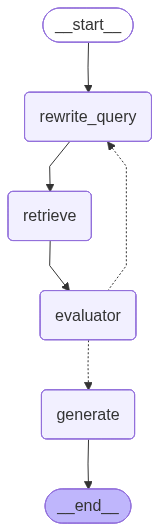

In [70]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
       )
    )
)